In [1]:
import enum
import typing
import itertools
import dataclasses
from pathlib import Path

import attrs
import numpy as np
from IPython import display

from arc25.dsl import types, primitives
from arc25.dsl import api as dsl
from arc25 import tools, dataset, sandbox

In [2]:
proj_root = Path("..").resolve()
data_path = proj_root / "data"
db_root = data_path / "solutions"
challenges_root = data_path / "arc-prize-2025.zip"

In [3]:
print(", ".join(types.__all__))

AnyImage, Axis4, Axis8, Canvas, Color, ColorArray, Coord, Dir4, Dir8, Image, Mask, MaskedImage, Paintable, Pattern, Rect, ShapeSpec, Transform, Vector


In [4]:
print(", ".join(primitives.__all__))

advance_pattern, apply_mask, cell_count, center_of_mass, connected_component, correlate_masks, count_colors, dilate, erode, extract_image, fill, find_bbox, find_holes, find_objects, identify_background, make_canvas, mask_all, mask_col, mask_color, mask_none, mask_row, mask_unpainted, masks_touch, most_common_colors, new_mask_like, paste, path_ray, path_segment, path_span, path_to_mask, pattern_cycle, pattern_dotted, pattern_solid, rect_to_mask, reduce_rect, round2grid, stroke, transform, vec2dir8


In [5]:
print(", ".join(dsl.__all__))

AnyImage, Axis4, Axis8, Canvas, Color, ColorArray, Coord, Dir4, Dir8, Image, Mask, MaskedImage, Paintable, Pattern, Rect, ShapeSpec, Transform, Vector, advance_pattern, apply_mask, cell_count, center_of_mass, connected_component, correlate_masks, count_colors, dilate, erode, extract_image, fill, find_bbox, find_holes, find_objects, identify_background, make_canvas, mask_all, mask_col, mask_color, mask_none, mask_row, mask_unpainted, masks_touch, most_common_colors, new_mask_like, paste, path_ray, path_segment, path_span, path_to_mask, pattern_cycle, pattern_dotted, pattern_solid, rect_to_mask, reduce_rect, round2grid, stroke, transform, vec2dir8, ROW, DIAG_ANTI, COL, DIAG_MAIN, ROW, COL, RIGHT, UP_RIGHT, UP, UP_LEFT, LEFT, DOWN_LEFT, DOWN, DOWN_RIGHT, RIGHT, UP, LEFT, DOWN, BLACK, BLUE, RED, GREEN, YELLOW, GRAY, MAGENTA, ORANGE, CYAN, BROWN, IDENTITY, FLIP_LR, FLIP_UD, ROTATE_180, FLIP_DIAG_MAIN, ROTATE_LEFT, ROTATE_RIGHT, FLIP_DIAG_ANTI


In [6]:
datasets = {}
for k in ["training", "evaluation", "test"]:
    datasets[k] = await dataset.Dataset.load(
        id=k,
        root=challenges_root,
        challenges=f"arc-agi_{k}_challenges.json",
        solutions=f"arc-agi_{k}_solutions.json" if k != "test" else None,
    )
ds = datasets["combined"] = dataset.Dataset(
    id="combined",
    challenges = dict(itertools.chain(*[ds.challenges.items() for ds in datasets.values()])),
)

In [7]:
solutions = await dataset.SolutionDB.load(db_root)
sol_with_code = sorted(k for k,v in solutions.solutions.items() if v.rule)
print(len(solutions.solutions), len(sol_with_code))

18 10


In [18]:
ckey = sol_with_code[8]

sol = solutions.solutions[ckey]
print(f"Challenbge {ckey}:")
print("Explanation:")
display.display(display.Markdown(sol.explanation))
print("Rule:")
display.display(display.Code(sol.rule, language="python"))


Challenbge ce039d91:
Explanation:


- Input are random gray cells on black background.
- Output background cells match input background cells.
- Output contains gray and blue foreground cells.
- Blue foreground cells are symmetric with respect to horizontal flip.


Rule:


def solution(input: Canvas) -> Canvas:
    fg_cells = ~mask_color(input, BLACK)
    symmetric = fg_cells & transform(fg_cells, FLIP_LR)
    output = fill(input, BLUE, clip=symmetric)
    return output

Overall: out.full_match=True out.example_match=1.0 out.cell_match=1.0
Train 0: v.full_match=True v.cell_match=1.0
Train 1: v.full_match=True v.cell_match=1.0
Train 2: v.full_match=True v.cell_match=1.0
Train 3: v.full_match=True v.cell_match=1.0
Test 0: v.full_match=True v.cell_match=1.0


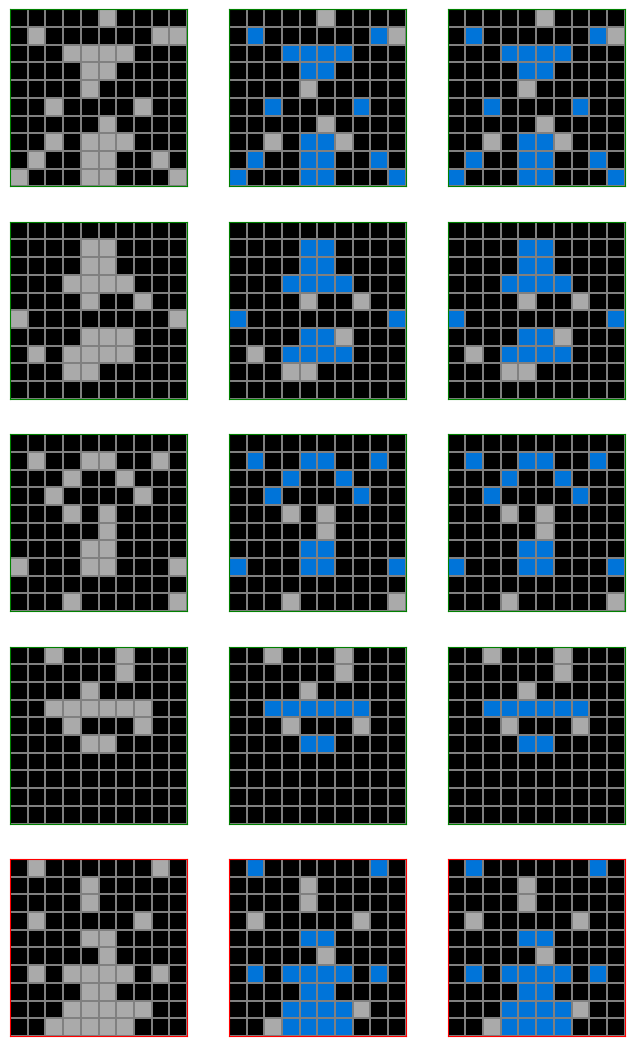

In [19]:
out = await sandbox.evaluate_solution(
    challenge=(chal := ds.challenges[ckey]),
    solution=solutions.solutions[ckey],
)
def ifp(s):
    if s:
        print(s)
print(f"Overall: {out.full_match=} {out.example_match=} {out.cell_match=}")
ifp(out.exec_info.stdout)
ifp(out.exec_info.stderr)
for split in ["train","test"]:
    for k,v in enumerate(getattr(out,f"{split}_eval")):
        print(f"{split.title()} {k}: {v.full_match=} {v.cell_match=}")
        ifp(v.exec_info.stdout)
        ifp(v.exec_info.stderr)
tools.show_test_case(
    out.get_eval_triples(),
    n_train = len(chal.train),
    width = 8,
)

In [17]:
out.exec_info

ExecutionInfo(error='NameError("name \'determine_bbox\' is not defined")', stdout='', stderr='Traceback (most recent call last):\n  File "/Users/yves/git-private/arc-2025/src/arc25/sandbox.py", line 100, in _evaluate_solution\n    actual = solver(io.input, examples)\n  File "/Users/yves/git-private/arc-2025/src/arc25/sandbox.py", line 85, in <lambda>\n    solver = lambda input, examples: _real_solver(input)\n                                     ~~~~~~~~~~~~^^^^^^^\n  File "<rule-code>", line 3, in solution\n    bbox = determine_bbox(fg_cells)\n           ^^^^^^^^^^^^^^\nNameError: name \'determine_bbox\' is not defined')